In [1]:
import matplotlib as mlt
import matplotlib.pyplot as plt

import numpy as np
import cv2
from Utils import *
from scripts.admedfilter import *

%matplotlib inline
mlt.rcParams['figure.figsize'] = (15,8)

# Image filtering

## 1. Smoothing / Noise removal

### 1.1 Example linear filters

Linear filtering operations involve weighted sums of a small vicinity of pixels.
* $g(i, j)=Σ_{(k,l)}  h(k,l)f(i+k, j+l)$  : The h component is the kernel/filter, the operation is called a correlation operation.
* $g(i, j)=Σ_{(k,l)}  h(k,l)f(i −k, j−l)$  : Here the signs of the offset in f are reversed, the operation is called a convolution operation.

Blurring/smoothing filters are low pass filters : they remove low frequency information from the image. Some examples :

Box filter = $\begin{bmatrix}
1 & 1 & 1\\
1 & 1 & 1\\
1 & 1 & 1
\end{bmatrix}*\frac{1}{9}$. Can be obtained with <code>cv2.blur(image,(3,3))</code>

Gaussian filter = $\begin{bmatrix}
1 & 2 & 1\\
2 & 4 & 2\\
1 & 2 & 1
\end{bmatrix}*\frac{1}{16}$. Can be obtained with <code>cv2.GaussianBlur(image,(3,3), stdv)</code> (this example has stdv close to 0.795).

Example image taken from [here](https://www.scientificamerican.com/podcast/episode/barred-owls-invade-the-sierra-nevada/).

In [2]:
source_image = 'data\owl_1_color.jpg'
img = cv2.imread(source_image, 1)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

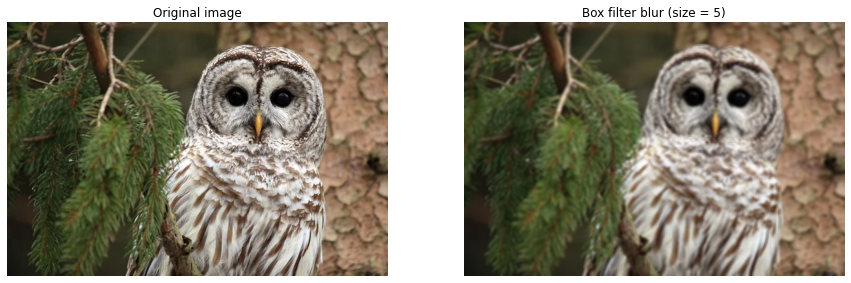

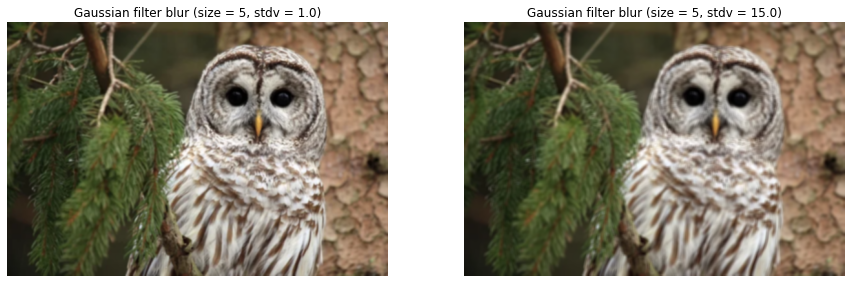

In [3]:
plt.subplot(1, 2, 1)
plt.title('Original image')
plt.imshow(img, vmin=0, vmax=255)
plt.axis('off')

bsize=5
plt.subplot(1, 2, 2)
plt.title('Box filter blur (size = {})'.format(bsize))
plt.imshow(cv2.blur(img,(bsize, bsize)), vmin=0, vmax=255)
plt.axis('off')
plt.show()

stdv = 1.
plt.subplot(1, 2, 1)
plt.title('Gaussian filter blur (size = {}, stdv = {})'.format(bsize, stdv))
plt.imshow(cv2.GaussianBlur(img,(bsize, bsize), stdv), vmin=0, vmax=255)
plt.axis('off')

stdv = 15.
plt.subplot(1, 2, 2)
plt.title('Gaussian filter blur (size = {}, stdv = {})'.format(bsize, stdv))
plt.imshow(cv2.GaussianBlur(img,(bsize, bsize), stdv), vmin=0, vmax=255)
plt.axis('off')
plt.show()

We can see that the images are smoothed, i.e. we are loosing some high frequency details.

### 1.2 Application on a noisy image

Let's consider an image that has "salt and pepper"/speckle noise, to highlight the limitations of above filters. The image is taken from [here](https://github.com/MeteHanC/Python-Median-Filter).

In [4]:
speckle_noisy_img = cv2.imread('data\sp_noise_image_2.png', 0)

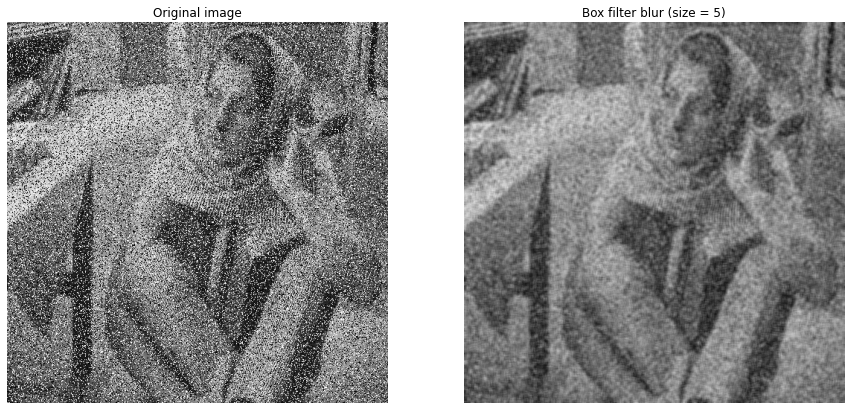

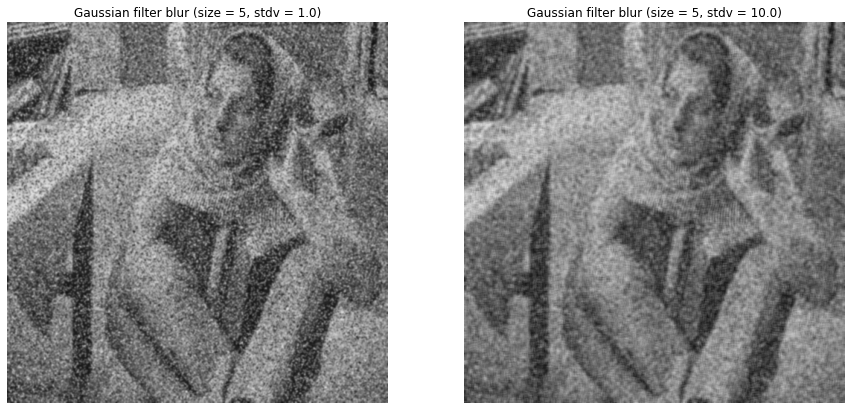

In [5]:
plt.subplot(1, 2, 1)
plt.title('Original image')
plt.imshow(speckle_noisy_img, 
           cmap='gray', vmin=0, vmax=255)
plt.axis('off')

bsize=5
plt.subplot(1, 2, 2)
plt.title('Box filter blur (size = {})'.format(bsize))
plt.imshow(cv2.blur(speckle_noisy_img,(bsize, bsize)), 
           cmap='gray', vmin=0, vmax=255)
plt.axis('off')
plt.show()

stdv = 1.
plt.subplot(1, 2, 1)
plt.title('Gaussian filter blur (size = {}, stdv = {})'.format(bsize, stdv))
plt.imshow(cv2.GaussianBlur(speckle_noisy_img,(bsize, bsize), stdv), 
           cmap='gray', vmin=0, vmax=255)
plt.axis('off')

stdv = 10.
plt.subplot(1, 2, 2)
plt.title('Gaussian filter blur (size = {}, stdv = {})'.format(bsize, stdv))
plt.imshow(cv2.GaussianBlur(speckle_noisy_img,(bsize, bsize), stdv), 
           cmap='gray', vmin=0, vmax=255)
plt.axis('off')
plt.show()

We can see that these filters are not really effective in removing this kind of noise also called *impulse noise*. We can consider an example of a **non-linear** smoothing filter which gives a better result : the median filter (instead taking an average of a window, we take the median pixel value). See implementation in scripts/admedfilter.py.

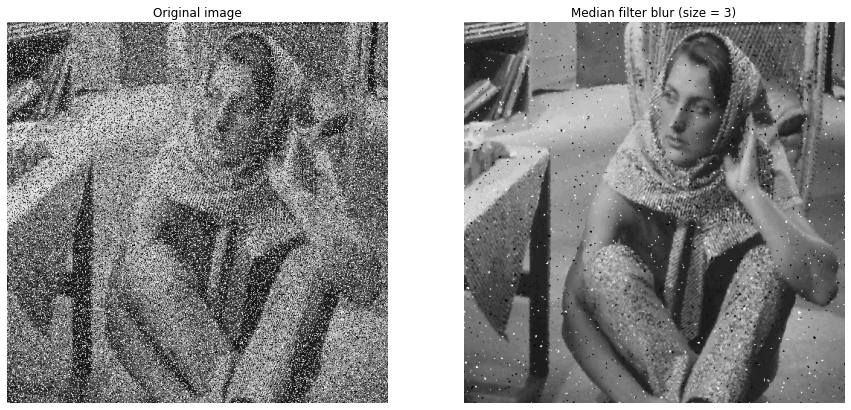

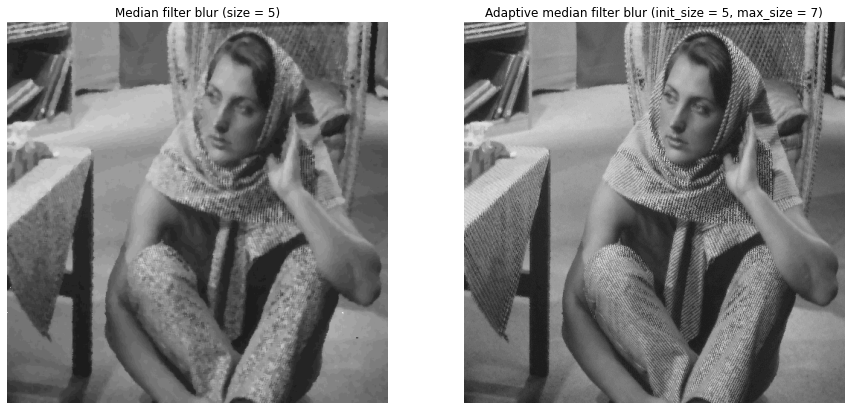

In [6]:
plt.subplot(1, 2, 1)
plt.title('Original image')
plt.imshow(speckle_noisy_img, 
           cmap='gray', vmin=0, vmax=255)
plt.axis('off')

bsize = 3
plt.subplot(1, 2, 2)
plt.title('Median filter blur (size = {})'.format(bsize))
plt.imshow(adaptive_median_filter(speckle_noisy_img, w_max = bsize, w_0 = bsize), 
           cmap='gray', vmin=0, vmax=255)
plt.axis('off')
plt.show()

bsize = 5
plt.subplot(1, 2, 1)
plt.title('Median filter blur (size = {})'.format(bsize))
plt.imshow(adaptive_median_filter(speckle_noisy_img, w_max = bsize, w_0 = bsize), 
           cmap='gray', vmin=0, vmax=255)
plt.axis('off')

bsize0 = 5
bsize_max = 7
plt.subplot(1, 2, 2)
plt.title('Adaptive median filter blur (init_size = {}, max_size = {})'.format(bsize0, bsize_max))
plt.imshow(adaptive_median_filter(speckle_noisy_img, w_max = bsize_max, w_0 = bsize0), 
           cmap='gray', vmin=0, vmax=255)
plt.axis('off')
plt.show()

The noise removal is better here, even if we observe some artefacts on the borders (which can be handled by padding the original image in a certain way) and a great loss of detail.

## 2. Sharpening / Edge enhancement

If we want to do the opposite operation, i. e. sharpen the image we can still use these filters. In fact, the sharpened an image is just the original image to which we add some of the difference between the original image and its blurred version.

<code>sharpened_image = original_image + gamma * (original_image - blurred_image) </code>
* If gamma = 1., this is called **unsharp masking**, the difference between the original and the blurred creates a mask that we apply on the original image.
* If gamma > 1., this is called **high-boost filtering** since we will give more weight to the high frequency information in the mask.

Of course gamma can be below one which will still produce the effect although more attenuated. One thing to keep in mind is that if we apply this formula directly, we may end up with pixel values outside of our usual range [0, 255] which will lead to saturation problems, some weird color patches will appear. One way to handle this is to use saturation thresholding which is applied as last step in the <code>cv2.addWeighted</code> function.

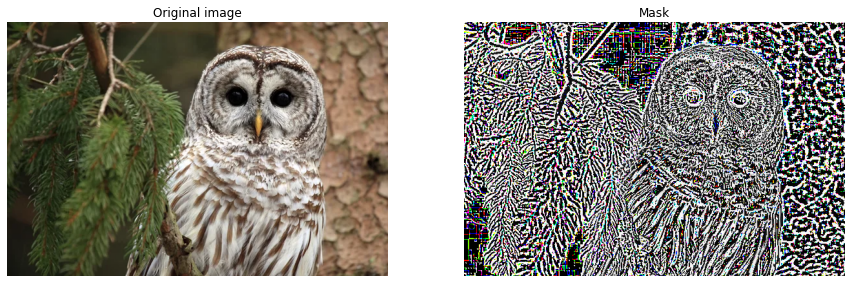

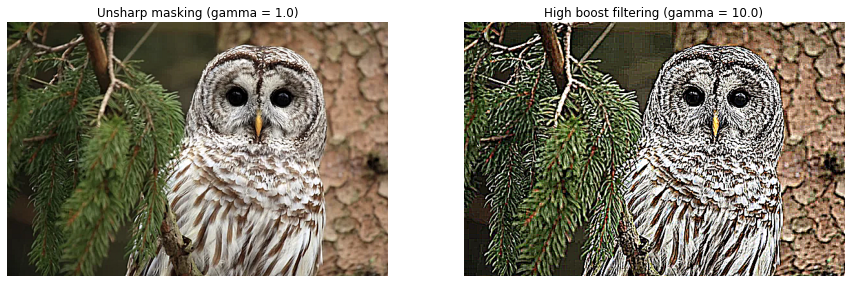

In [7]:
plt.subplot(1, 2, 1)
plt.title('Original image')
plt.imshow(img)
plt.axis('off')

blurred_img = cv2.GaussianBlur(img,(5,5), 5.)
plt.subplot(1, 2, 2)
plt.title('Mask')
plt.imshow(img - blurred_img)
plt.axis('off')
plt.show()

gamma = 1.
unsharp_masked_img = cv2.addWeighted(img, 1 + gamma, blurred_img, - gamma, 0, None)
plt.subplot(1, 2, 1)
plt.title('Unsharp masking (gamma = {})'.format(gamma))
plt.imshow(unsharp_masked_img)
plt.axis('off')

gamma = 10.
highboost_filtered_img = cv2.addWeighted(img, 1 + gamma, blurred_img, - gamma, 0, None)
plt.subplot(1, 2, 2)
plt.title('High boost filtering (gamma = {})'.format(gamma))
plt.imshow(highboost_filtered_img)
plt.axis('off')
plt.show()